In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
#https://www.kaggle.com/imranzaman5202/twitter-sentiment-analysis-using-nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading data
import pandas as pd

path="drive/My Drive/IDC/Deep_Learning/Final_Project/Data/"
df = pd.read_csv(path + 'lichess-08-2014.csv')


In [4]:
df.head()

,Unnamed: 0,PGN,Mode,Result,Average Rating,Rating Difference,Termination Type
0,0,1. e4 g6 2. d4 Bg7 3. c3 d6 4. Qf3 Nf6 5. h3 O...,Classical,Black Wins,1538,-262,Time forfeit
1,1,1. d4 Nf6 2. c4 g6 3. a3 Bg7 4. Nf3 O-O 5. Nc3...,Blitz,Black Wins,1492,-220,Time forfeit
2,2,1. e4 c5 2. Qf3 e5 3. Bc4 Nf6 4. Nh3 h6 5. g4 ...,Blitz,White Wins,1413,213,Normal
3,3,1. e4 e5 2. Nf3 d6 3. Nc3 f5 4. exf5 Bxf5 5. d...,Blitz,Black Wins,1444,-358,Normal
4,4,1. e4 e6 2. d4 d5 3. Nc3 Nf6 4. e5 Ne4 5. Nce2...,Bullet,White Wins,1931,117,Normal


In [5]:
# pre processing adding score per player.

df['white_score'] = (2 * df['Average Rating'] + df['Rating Difference']) / 2
df['black_score'] = 2 * df['Average Rating'] - df['white_score']

In [6]:
df.head()

,Unnamed: 0,PGN,Mode,Result,Average Rating,Rating Difference,Termination Type,white_score,black_score
0,0,1. e4 g6 2. d4 Bg7 3. c3 d6 4. Qf3 Nf6 5. h3 O...,Classical,Black Wins,1538,-262,Time forfeit,1407.0,1669.0
1,1,1. d4 Nf6 2. c4 g6 3. a3 Bg7 4. Nf3 O-O 5. Nc3...,Blitz,Black Wins,1492,-220,Time forfeit,1382.0,1602.0
2,2,1. e4 c5 2. Qf3 e5 3. Bc4 Nf6 4. Nh3 h6 5. g4 ...,Blitz,White Wins,1413,213,Normal,1519.5,1306.5
3,3,1. e4 e5 2. Nf3 d6 3. Nc3 f5 4. exf5 Bxf5 5. d...,Blitz,Black Wins,1444,-358,Normal,1265.0,1623.0
4,4,1. e4 e6 2. d4 d5 3. Nc3 Nf6 4. e5 Ne4 5. Nce2...,Bullet,White Wins,1931,117,Normal,1989.5,1872.5


(-1000.0, 1000.0)

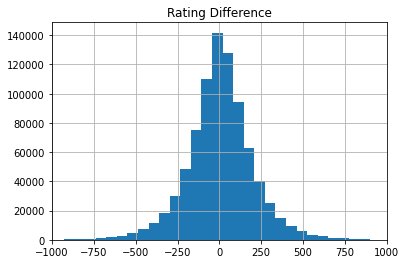

In [7]:
hist = df['Rating Difference'].hist(bins=50)
plt.title('Rating Difference')
plt.xlim(-1000,1000)


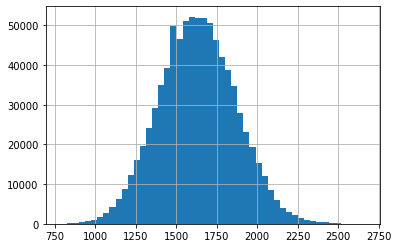

In [8]:
hist = df['white_score'].hist(bins=50)

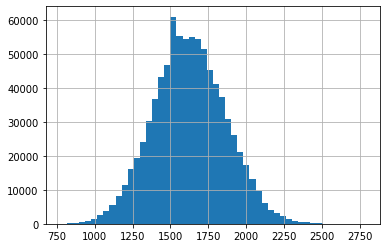

In [9]:
hist = df['black_score'].hist(bins=50)

Text(0.5, 1.0, 'Game Result')

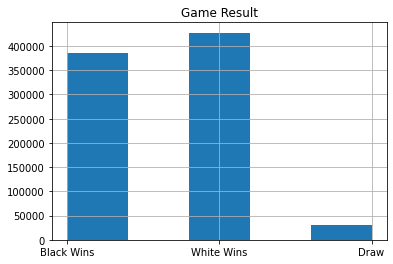

In [10]:
hist = df['Result'].hist(bins=5)
plt.title('Game Result')

In [11]:
df['black_score'].mean()

1625.6109952207582

as we can see the white players wins more then the black. It makes sense and gets along with the fact that in chess the white player has an advantage also as we can see the white's player are ranked in average heiger.

In [12]:
# calculate the number of moves
df['length']=df['PGN'].str.count('\.')

In [13]:
df.head()

,Unnamed: 0,PGN,Mode,Result,Average Rating,Rating Difference,Termination Type,white_score,black_score,length
0,0,1. e4 g6 2. d4 Bg7 3. c3 d6 4. Qf3 Nf6 5. h3 O...,Classical,Black Wins,1538,-262,Time forfeit,1407.0,1669.0,41
1,1,1. d4 Nf6 2. c4 g6 3. a3 Bg7 4. Nf3 O-O 5. Nc3...,Blitz,Black Wins,1492,-220,Time forfeit,1382.0,1602.0,36
2,2,1. e4 c5 2. Qf3 e5 3. Bc4 Nf6 4. Nh3 h6 5. g4 ...,Blitz,White Wins,1413,213,Normal,1519.5,1306.5,13
3,3,1. e4 e5 2. Nf3 d6 3. Nc3 f5 4. exf5 Bxf5 5. d...,Blitz,Black Wins,1444,-358,Normal,1265.0,1623.0,18
4,4,1. e4 e6 2. d4 d5 3. Nc3 Nf6 4. e5 Ne4 5. Nce2...,Bullet,White Wins,1931,117,Normal,1989.5,1872.5,19


(0.0, 250.0)

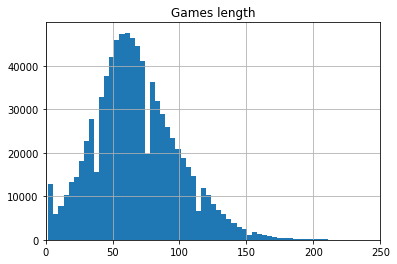

In [14]:
GL=df['length']*2
hist = GL.hist(bins=100)

plt.title('Games length')
plt.xlim(0,250)

In [15]:
len(df['length'])

843230

In [16]:
minGameSize=24
longGames = df[(df['length'] > minGameSize) ]



consider removing the draw games



In [17]:
len(longGames)

603770

In [18]:
longGames['Result'][longGames['Result']=='White Wins']=1

In [19]:
longGames["Result"][longGames["Result"] == "Black Wins" ] = 0

In [20]:
longGamesNoDraw = longGames[(longGames['Result'] != "Draw") ]

In [21]:
len(longGamesNoDraw)

574866

In [22]:
#max size of game
longGames['length'].max()


191

In [23]:
longGamesNoDraw['PGN'] = longGamesNoDraw['PGN'].str.split(' 26.').str[0]

In [24]:
longGamesNoDraw['PGN'][705]

'1. e4 b6 2. d4 Bb7 3. Bd3 e6 4. f4 Nf6 5. Qe2 Be7 6. Nf3 O-O 7. O-O h6 8. c3 Nh7 9. h3 d6 10. a4 a5 11. Na3 f6 12. f5 e5 13. d5 Ba6 14. Nb5 Bxb5 15. Bxb5 Ng5 16. Nxg5 fxg5 17. Qh5 Nd7 18. Bc6 Rb8 19. Qg6 Nc5 20. Re1 Nd3 21. Re3 Nf4 22. Bd7 Nxg6 23. Be6+ Kh7 24. fxg6+ Kxg6 25. Bf5+ Rxf5'

In [25]:
longGamesNoDraw['PGN']

0         1. e4 g6 2. d4 Bg7 3. c3 d6 4. Qf3 Nf6 5. h3 O...
1         1. d4 Nf6 2. c4 g6 3. a3 Bg7 4. Nf3 O-O 5. Nc3...
6         1. d4 c6 2. Nf3 d5 3. g3 Nf6 4. Bg2 e6 5. O-O ...
7         1. e4 e6 2. d4 d5 3. Nc3 c5 4. exd5 exd5 5. dx...
8         1. f4 d5 2. Nf3 c5 3. e3 Bg4 4. Bb5+ Nd7 5. Bx...
                                ...                        
843225    1. d4 a6 2. Nf3 b5 3. Bf4 Bb7 4. Nc3 d6 5. e4 ...
843226    1. d3 d5 2. Nf3 f6 3. e3 e5 4. Nxe5 g6 5. Nf3 ...
843227    1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 d5 5. ex...
843228    1. e4 c5 2. f4 e6 3. Nf3 Ne7 4. c3 d5 5. Bb5+ ...
843229    1. e4 d6 2. Nf3 e6 3. Bc4 Qe7 4. d4 Nd7 5. Nc3...
Name: PGN, Length: 574866, dtype: object

In [26]:
PGNs = longGamesNoDraw["PGN"]
for i in range(25):
  PGNs = [a.replace(str(i) +". ", "") for a in PGNs]

In [27]:
PGNs

['e4 g6 d4 Bg7 c3 d6 Qf3 Nf6 h3 O-O Bg5 Nbd7 Bc4 a6 h4 b5 Bd5 Nxd5 1exd5 Bb7 1h5 Nf6 1h6 Bh8 1Bxf6 Bxf6 1Nd2 Qd7 1Qh3 Qxh3 1Rxh3 Bxd5 1g4 Be6 1Rg3 Bh4 1Rg2 f5 2Ngf3 Bf6 2g5 Bh8 2Nh4 c5 2Rh2 cxd4 2cxd4 Bxd4 2Nxg6 hxg6',
 'd4 Nf6 c4 g6 a3 Bg7 Nf3 O-O Nc3 a5 Bf4 d6 e3 Nbd7 Be2 Nh5 Bg3 Nxg3 1fxg3 Nf6 1O-O Ng4 1Qd2 e5 1dxe5 Nxe5 1Nxe5 Bxe5 1Rf2 Be6 1b3 Qg5 1Raf1 f5 1Bf3 c6 1Ne2 Rfe8 2Nf4 Bf7 2b4 axb4 2Qxb4 Qe7 2Qb3 Ra6 2g4 Rea8 2gxf5 Rxa3',
 'd4 c6 Nf3 d5 g3 Nf6 Bg2 e6 O-O Be7 Bd2 c5 dxc5 Bxc5 c3 a6 b4 b5 1a4 Bd6 1axb5 Bb7 1Ra5 Bc7 1Ra2 axb5 1Rxa8 Bxa8 1Qc2 Bb7 1Bg5 O-O 1Bxf6 Qxf6 1Nd4 Qd8 1Nxb5 Bd6 2Nd4 Be7 2f4 Bf6 2Nd2 Qc7 2Qd3 Rc8 2N2f3 Qxc3 2Qxc3 Rxc3',
 'e4 e6 d4 d5 Nc3 c5 exd5 exd5 dxc5 Bxc5 Qxd5 Qxd5 Nxd5 Bd6 Bf4 Bxf4 Nxf4 Nf6 1Nf3 O-O 1O-O-O Nc6 1Bb5 Nb4 1a3 Nc6 1Bxc6 bxc6 1h3 Rb8 1g4 c5 1g5 Ne4 1Rhf1 c4 1Ne2 Bxh3 2Rg1 Nxf2 2Rd4 Rfe8 2Nc3 Bf5 2Rxc4 Ne4 2Nd4 Nxc3 2bxc3 Bg6',
 'f4 d5 Nf3 c5 e3 Bg4 Bb5+ Nd7 Bxd7+ Qxd7 Ne5 Bxd1 Nxd7 Bxc2 Nxf8 Kxf8 Na3 Bd3 1b3 Nf6 1Bb2 e6 1Bxf6 gxf6 1Rc1

consider removing the X's and the +'s
because they multiplay our vocabilary 

In [28]:
longGamesNoDraw["PGN"]=PGNs

In [29]:
longGamesNoDraw

,Unnamed: 0,PGN,Mode,Result,Average Rating,Rating Difference,Termination Type,white_score,black_score,length
0,0,e4 g6 d4 Bg7 c3 d6 Qf3 Nf6 h3 O-O Bg5 Nbd7 Bc4...,Classical,0,1538,-262,Time forfeit,1407.0,1669.0,41
1,1,d4 Nf6 c4 g6 a3 Bg7 Nf3 O-O Nc3 a5 Bf4 d6 e3 N...,Blitz,0,1492,-220,Time forfeit,1382.0,1602.0,36
6,6,d4 c6 Nf3 d5 g3 Nf6 Bg2 e6 O-O Be7 Bd2 c5 dxc5...,Bullet,1,1662,196,Time forfeit,1760.0,1564.0,51
7,7,e4 e6 d4 d5 Nc3 c5 exd5 exd5 dxc5 Bxc5 Qxd5 Qx...,Bullet,0,1788,81,Time forfeit,1828.5,1747.5,52
8,8,f4 d5 Nf3 c5 e3 Bg4 Bb5+ Nd7 Bxd7+ Qxd7 Ne5 Bx...,Bullet,0,1922,54,Normal,1949.0,1895.0,38
...,...,...,...,...,...,...,...,...,...,...
843225,843225,d4 a6 Nf3 b5 Bf4 Bb7 Nc3 d6 e4 b4 Ne2 Bxe4 c3 ...,Blitz,0,1673,-130,Time forfeit,1608.0,1738.0,62
843226,843226,d3 d5 Nf3 f6 e3 e5 Nxe5 g6 Nf3 Bg7 Bd2 Ne7 Bc3...,Blitz,0,1673,143,Time forfeit,1744.5,1601.5,43
843227,843227,e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5 exd5 Nxd5 Qf3 Qxg...,Blitz,1,1424,-69,Normal,1389.5,1458.5,55
843228,843228,e4 c5 f4 e6 Nf3 Ne7 c3 d5 Bb5+ Bd7 Bxd7+ Qxd7 ...,Blitz,0,1768,-34,Normal,1751.0,1785.0,41


In [30]:
temp = [a.split() for a in PGNs ]
#tokenize

In [31]:
temp[0]

['e4',
 'g6',
 'd4',
 'Bg7',
 'c3',
 'd6',
 'Qf3',
 'Nf6',
 'h3',
 'O-O',
 'Bg5',
 'Nbd7',
 'Bc4',
 'a6',
 'h4',
 'b5',
 'Bd5',
 'Nxd5',
 '1exd5',
 'Bb7',
 '1h5',
 'Nf6',
 '1h6',
 'Bh8',
 '1Bxf6',
 'Bxf6',
 '1Nd2',
 'Qd7',
 '1Qh3',
 'Qxh3',
 '1Rxh3',
 'Bxd5',
 '1g4',
 'Be6',
 '1Rg3',
 'Bh4',
 '1Rg2',
 'f5',
 '2Ngf3',
 'Bf6',
 '2g5',
 'Bh8',
 '2Nh4',
 'c5',
 '2Rh2',
 'cxd4',
 '2cxd4',
 'Bxd4',
 '2Nxg6',
 'hxg6']

In [32]:
longGamesNoDraw["PGN"]=temp

In [33]:
longGamesNoDraw['PGN']

0         [e4, g6, d4, Bg7, c3, d6, Qf3, Nf6, h3, O-O, B...
1         [d4, Nf6, c4, g6, a3, Bg7, Nf3, O-O, Nc3, a5, ...
6         [d4, c6, Nf3, d5, g3, Nf6, Bg2, e6, O-O, Be7, ...
7         [e4, e6, d4, d5, Nc3, c5, exd5, exd5, dxc5, Bx...
8         [f4, d5, Nf3, c5, e3, Bg4, Bb5+, Nd7, Bxd7+, Q...
                                ...                        
843225    [d4, a6, Nf3, b5, Bf4, Bb7, Nc3, d6, e4, b4, N...
843226    [d3, d5, Nf3, f6, e3, e5, Nxe5, g6, Nf3, Bg7, ...
843227    [e4, e5, Nf3, Nc6, Bc4, Nf6, Ng5, d5, exd5, Nx...
843228    [e4, c5, f4, e6, Nf3, Ne7, c3, d5, Bb5+, Bd7, ...
843229    [e4, d6, Nf3, e6, Bc4, Qe7, d4, Nd7, Nc3, e5, ...
Name: PGN, Length: 574866, dtype: object

In [34]:
X=longGamesNoDraw.PGN
y=longGamesNoDraw.Result

In [35]:
type(y)

pandas.core.series.Series

In [36]:
max_len = 50
dropOut = 0.5
epochs = 6
batch_size = 80
num_words=8*8*6*2*3+10


In [37]:
tok = Tokenizer(num_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [38]:
sequences_matrix.shape

(574866, 50)

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [40]:
def LSTM_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(num_words,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(dropOut)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

def GRU_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(num_words,50,input_length=max_len)(inputs) #step2
    layer = GRU(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(dropOut)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

def RNN_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(num_words,50,input_length=max_len)(inputs) #step2
    layer = SimpleRNN(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(dropOut)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it


In [41]:
model = GRU_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])  

In [42]:
type(X_train)

numpy.ndarray

In [43]:
type(Y_train)

pandas.core.series.Series

In [44]:
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)

In [45]:
history =model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
4528/4528 [==============================] - 74s 15ms/step - loss: 0.6485 - accuracy: 0.6127 - val_loss: 0.6379 - val_accuracy: 0.6306
Epoch 2/6
4528/4528 [==============================] - 67s 15ms/step - loss: 0.6300 - accuracy: 0.6398 - val_loss: 0.6336 - val_accuracy: 0.6365
Epoch 3/6
4528/4528 [==============================] - 68s 15ms/step - loss: 0.6276 - accuracy: 0.6423 - val_loss: 0.6328 - val_accuracy: 0.6365
Epoch 4/6
4528/4528 [==============================] - 67s 15ms/step - loss: 0.6256 - accuracy: 0.6443 - val_loss: 0.6319 - val_accuracy: 0.6359
Epoch 5/6
4528/4528 [==============================] - 69s 15ms/step - loss: 0.6239 - accuracy: 0.6470 - val_loss: 0.6309 - val_accuracy: 0.6369
Epoch 6/6
4528/4528 [==============================] - 68s 15ms/step - loss: 0.6222 - accuracy: 0.6484 - val_loss: 0.6301 - val_accuracy: 0.6376
Training finished !!


In [46]:
X_test=np.asarray(X_test).astype(np.float32)
Y_test=np.asarray(Y_test).astype(np.float32)

In [47]:
accr1 = model.evaluate(X_test,Y_test)

5390/5390 [==============================] - 31s 6ms/step - loss: 0.6281 - accuracy: 0.6407


In [51]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data 

Test set
  Accuracy: 0.64


In [ ]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 



confusion matrix


[[53152 30337]
 [31631 57340]]




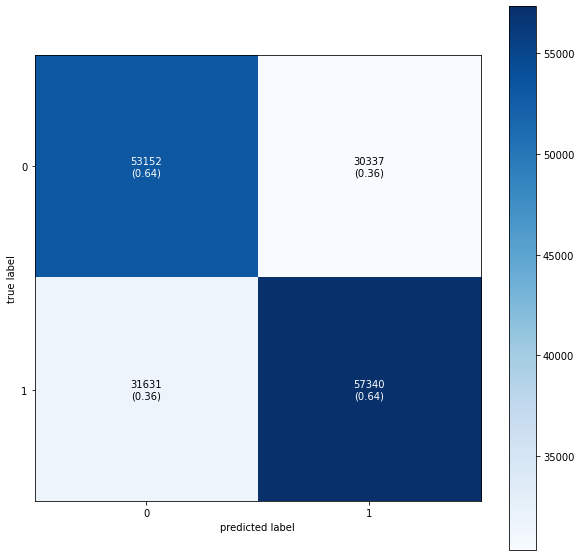

In [54]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()